In [7]:
import torch
from tokenizer.tokenizer_image.vq_model import VQ_models
# from fvcore.nn import FlopCountAnalysis
from ptflops import get_model_complexity_info


model = VQ_models['VQ-16']()
model.eval()
# print(model)
resolution = 128
# n_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
# print('number of params:', n_parameters / 1e6)
# inputs = (torch.randn(1, 3, resolution, resolution),)
inputs = (3, resolution, resolution)
macs, params = get_model_complexity_info(model, inputs, print_per_layer_stat=True)
# print("macs: ", macs, "params:", params)

VQModel(
  71.75 M, 99.818% Params, 48.88 GMac, 99.936% MACs, 
  (encoder): Encoder(
    29.3 M, 40.758% Params, 17.29 GMac, 35.350% MACs, 
    (conv_in): Conv2d(3.58 k, 0.005% Params, 58.72 MMac, 0.120% MACs, 3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv_blocks): ModuleList(
      (0): Module(
        738.94 k, 1.028% Params, 10.29 GMac, 21.047% MACs, 
        (res): ModuleList(
          (0-1): 2 x ResnetBlock(
            295.68 k, 0.411% Params, 4.84 GMac, 9.905% MACs, 
            (norm1): GroupNorm(256, 0.000% Params, 4.19 MMac, 0.009% MACs, 32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(147.58 k, 0.205% Params, 2.42 GMac, 4.944% MACs, 128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(256, 0.000% Params, 4.19 MMac, 0.009% MACs, 32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(0, 0.000% Params, 0.0 Mac, 0.000% MACs, p=0.0, inplace=False)
            (conv2): Conv2d(147.58 k, 0.205% Params

In [5]:
import torch
from tokenizer.tokenizer_image.efficient_vq_model import VQ_models
# from fvcore.nn import FlopCountAnalysis
from ptflops import get_model_complexity_info


model = VQ_models['VQ-16']()
model.eval()
# print(model)
resolution = 128
# n_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
# print('number of params:', n_parameters / 1e6)
# inputs = (torch.randn(1, 3, resolution, resolution),)
inputs = (3, resolution, resolution)
macs, params = get_model_complexity_info(model, inputs, print_per_layer_stat=True)
# print("macs: ", macs, "params:", params)

VQModel(
  71.42 M, 99.817% Params, 46.97 GMac, 99.934% MACs, 
  (encoder): Encoder(
    31.35 M, 43.808% Params, 17.81 GMac, 37.903% MACs, 
    (conv_in): Conv2d(3.58 k, 0.005% Params, 58.72 MMac, 0.125% MACs, 3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv_blocks): ModuleList(
      (0): Module(
        738.94 k, 1.033% Params, 10.29 GMac, 21.902% MACs, 
        (res): ModuleList(
          (0-1): 2 x ResnetBlock(
            295.68 k, 0.413% Params, 4.84 GMac, 10.308% MACs, 
            (norm1): GroupNorm(256, 0.000% Params, 4.19 MMac, 0.009% MACs, 32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(147.58 k, 0.206% Params, 2.42 GMac, 5.145% MACs, 128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(256, 0.000% Params, 4.19 MMac, 0.009% MACs, 32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(0, 0.000% Params, 0.0 Mac, 0.000% MACs, p=0.0, inplace=False)
            (conv2): Conv2d(147.58 k, 0.206% Para

In [1]:
import torch
import torch.nn.functional as F
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import random


sample_folder_dir = "reconstructions/VQ-16-imagenet-size-256-size-256-codebook-size-16384-dim-8-seed-0"
sample_images = random.sample(list(range(50000)), 5000)
sample_images.sort()
patches_by_code = [[] for _ in range(16384)]
for i in sample_images:
    indices = torch.load(f"{sample_folder_dir}/{i:06d}_idx.pt")
    image = Image.open(f"{sample_folder_dir}/{i:06d}_gt.png")
    image = torch.tensor(np.array(image)).permute(2, 0, 1).to(torch.float) / 255.0

    patches = image.unfold(1, 16, 16).unfold(2, 16, 16).permute(1, 2, 3, 4, 0)
    for x in range(indices.shape[0]):
        for y in range(indices.shape[1]):
            patches_by_code[indices[x, y]].append(patches[x, y])

32 657


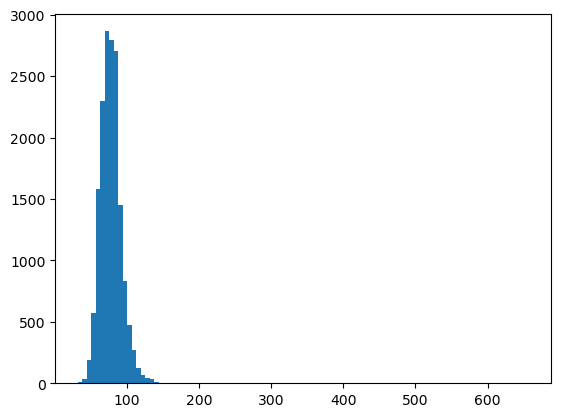

In [5]:

num_of_patches = [len(patches_by_code[i]) for i in range(16384)]
print(min(num_of_patches), max(num_of_patches))
plt.hist(num_of_patches, 100)
plt.show()

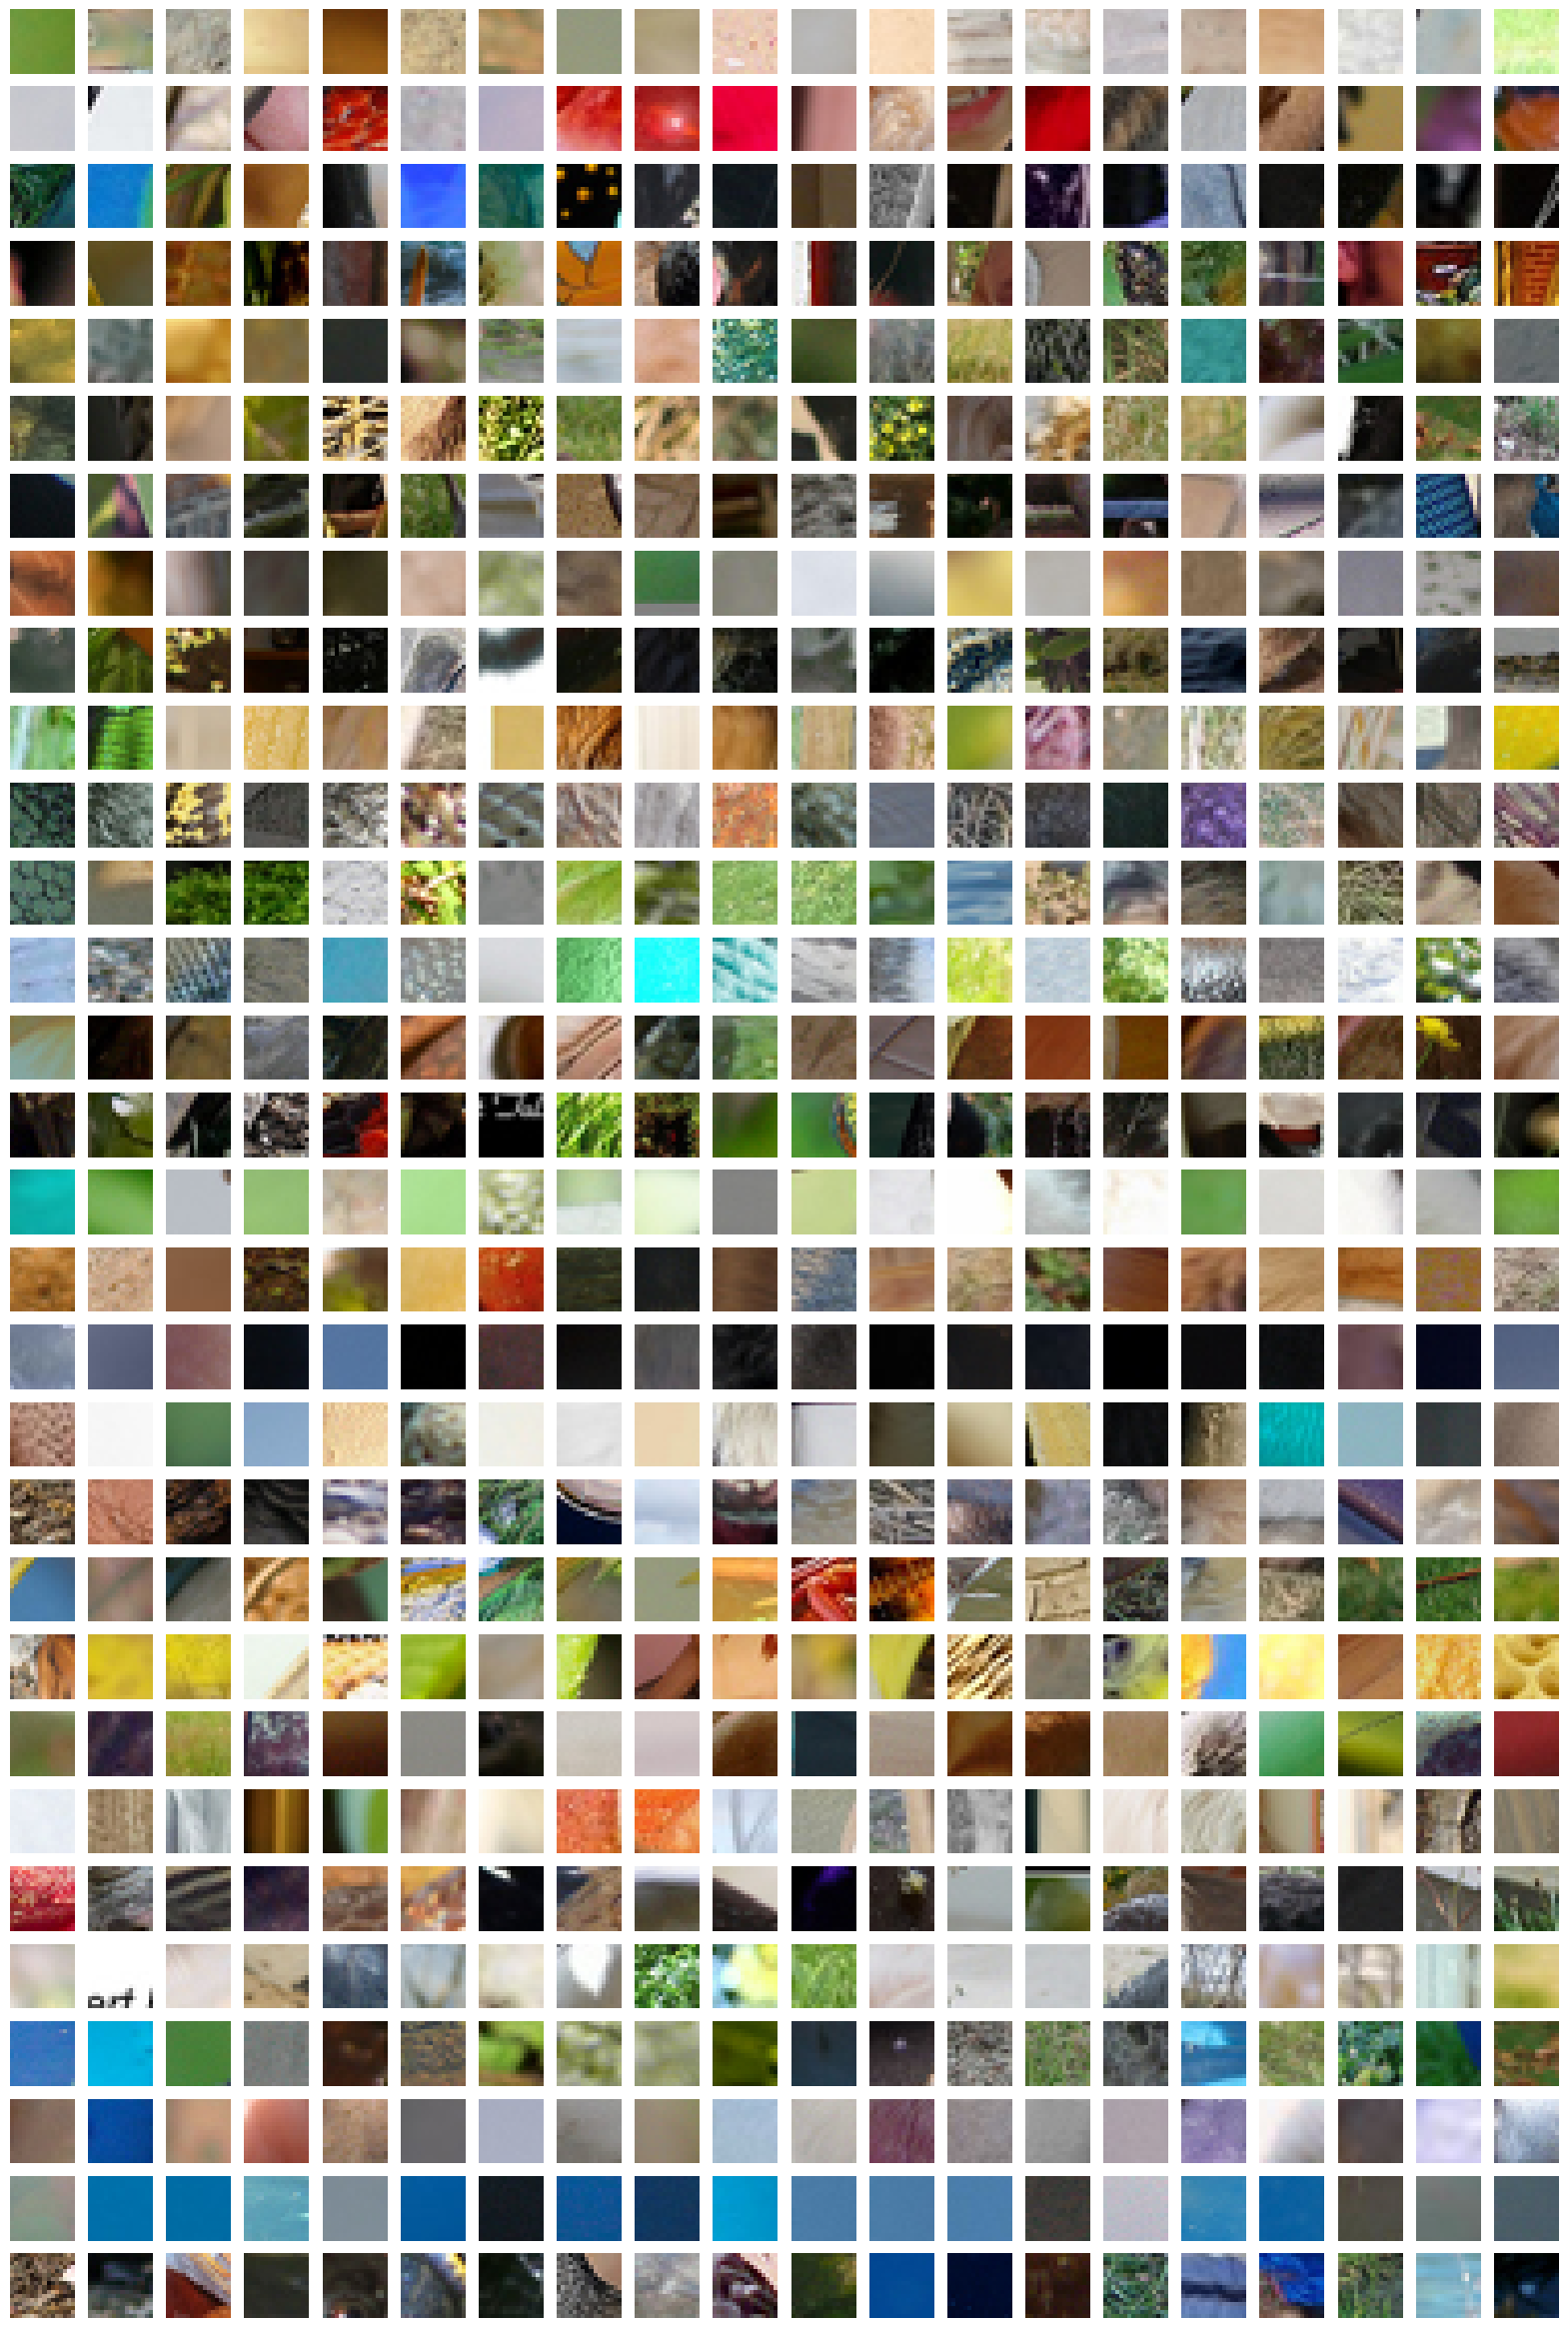

In [2]:
show_num_code = 30
show_num_patch = 20
show_code_offset = 0

fig, axs = plt.subplots(show_num_code, show_num_patch, figsize=(show_num_patch, show_num_code))


for code in range(show_num_code):
    for i in range(show_num_patch):
        if i >= len(patches_by_code[code + show_code_offset]):
            axs[code, i].axis('off')
            continue
        axs[code, i].axis('off')
        axs[code, i].imshow(patches_by_code[code + show_code_offset][i])

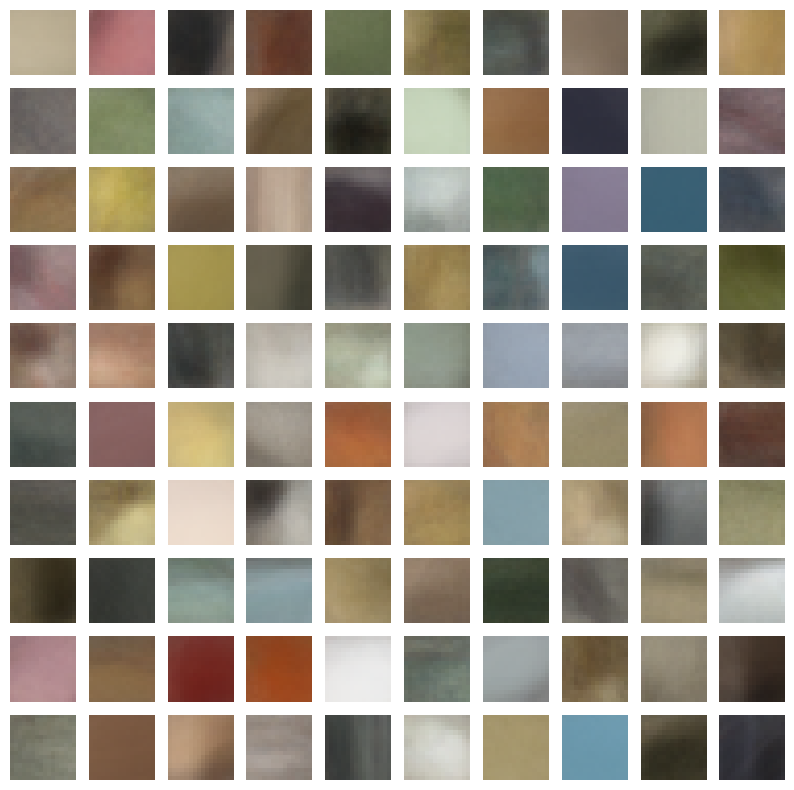

In [8]:
import pandas as pd
import matplotlib.pyplot as plt


code_features = []

for code in range(16384):
    patches = patches_by_code[code]
    code_features.append(torch.stack([patch for patch in patches]).mean(0))

fig, axs = plt.subplots(10, 10, figsize=(10, 10))
for i in range(10):
    for j in range(10):
        axs[i, j].axis('off')
        axs[i, j].imshow(code_features[i * 10 + j])
plt.show()

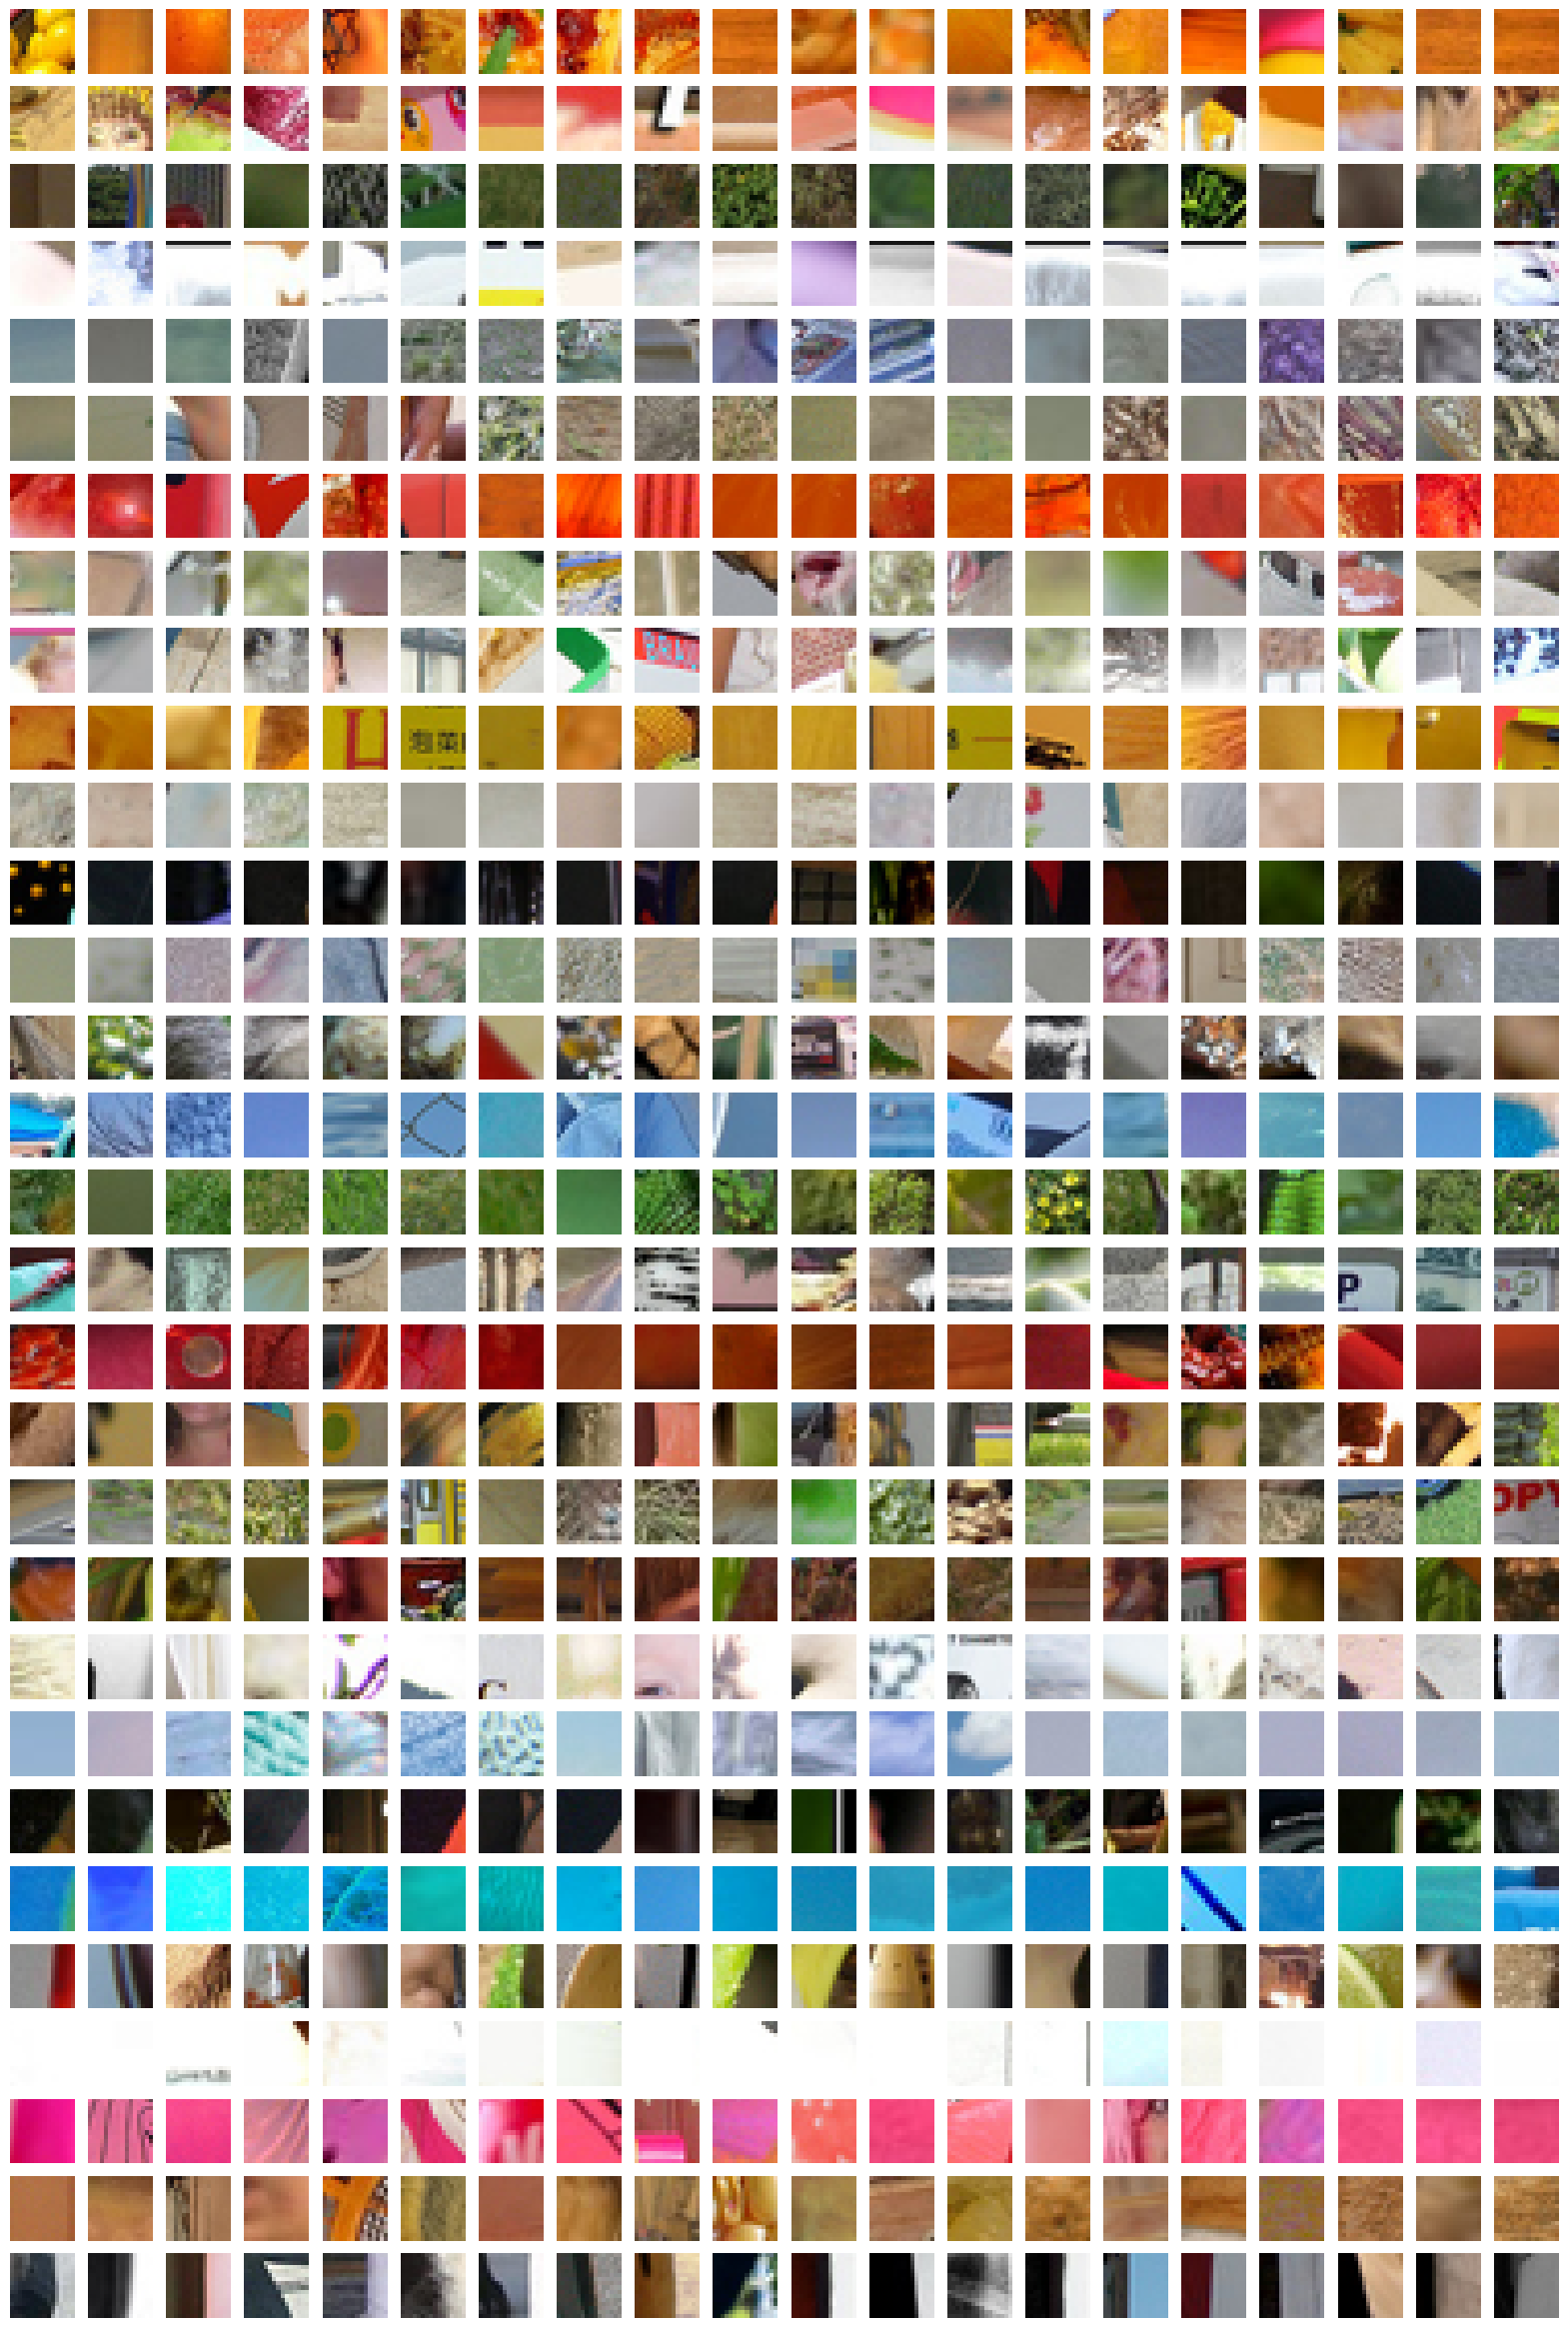

In [10]:
from sklearn.cluster import KMeans

all_patches = torch.stack(sum(patches_by_code[:100], []))
all_patches = all_patches.reshape(all_patches.shape[0], -1).numpy()

kmeans = KMeans(n_clusters=100, random_state=0).fit(all_patches)
cluster_centers = kmeans.cluster_centers_
cluster_indices = kmeans.predict(all_patches)
patches_by_cluster = [[] for _ in range(100)]
for i in range(all_patches.shape[0]):
    patches_by_cluster[cluster_indices[i]].append(all_patches[i].reshape(16, 16, 3))

# fig, axs = plt.subplots(10, 10, figsize=(10, 10))
# for i in range(10):
#     for j in range(10):
#         axs[i, j].axis('off')
#         axs[i, j].imshow(cluster_centers[i * 10 + j].reshape(16, 16, 3))
# plt.show()

show_num_cluster = 30
show_num_patch = 20
show_code_offset = 0

fig, axs = plt.subplots(show_num_cluster, show_num_patch, figsize=(show_num_patch, show_num_cluster))
for code in range(show_num_cluster):
    for i in range(show_num_patch):
        if i >= len(patches_by_code[code + show_code_offset]):
            axs[code, i].axis('off')
            continue
        axs[code, i].axis('off')
        axs[code, i].imshow(patches_by_cluster[code + show_code_offset][i])

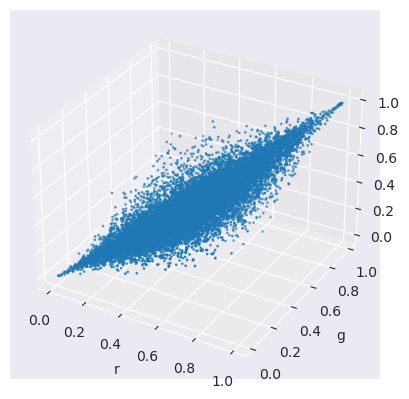

In [13]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set_style("darkgrid")

ax = plt.axes(projection="3d")

ax.scatter3D([code[0] for code in code_features], [code[1] for code in code_features], [code[2] for code in code_features], s=1)
ax.set_xlabel("r")
ax.set_ylabel("g")
ax.set_zlabel("b")
plt.show()

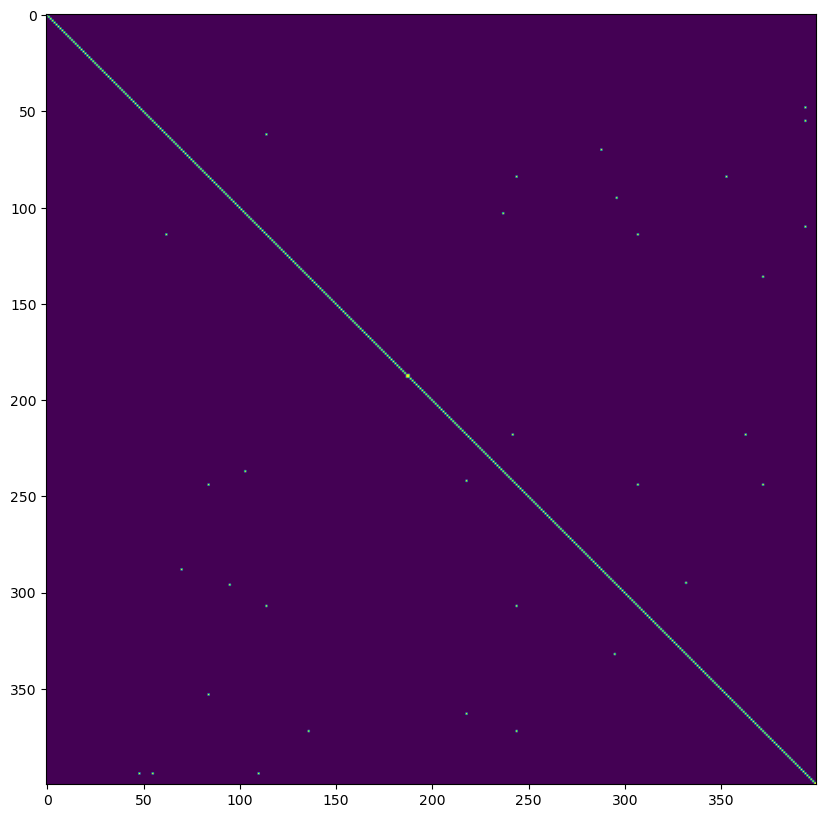

In [17]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt


ckpt = torch.load("outputs/vq_ds16_c2i.pt")
model = ckpt["model"]
code_book = model["quantize.embedding.weight"]
code_book = F.normalize(code_book, p=2, dim=-1)

sim = code_book @ code_book.mT
plt.figure(figsize=(10, 10))
plt.imshow(sim[:400, :400] > 0.90)
plt.show()

In [18]:
num_similar = (sim > 0.9).sum(0)
print(sum(num_similar > 1))

tensor(7398)


In [20]:
score = torch.randn_like(model["quantize.embedding.weight"])
# score = score.normal_()
score = F.normalize(score, p=2, dim=-1)
random_sim = score @ score.mT
num_random_sim = (random_sim > 0.9).sum(0)
print(sum(num_random_sim > 1))

tensor(16375)


In [6]:
import torch

B, H, W, T = 64, 16, 16, 128
K = 16
x = torch.rand(B, H, W, T, 2)

fft_x = torch.fft.fft(x, dim=3)
print(fft_x.shape)
filtered_fft_x = fft_x[:, :, :, :16]

reshaped_x = torch.cat([filtered_fft_x.real, filtered_fft_x.imag], dim=4)
print(reshaped_x.shape)

torch.Size([64, 16, 16, 128, 2])
torch.Size([64, 16, 16, 16, 4])
